Let's train a very simple non-linear multivariate regression model using PyTorch.

In [0]:
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

Create a simple PyTorch Module. This Module models the function:

$y = M_2 (M_1 x + b_1) + b_2$

And you want to minimize:

$L = || y - y_{observed} ||^2 + \lambda_1 ||M_1||_F + + \lambda_2 ||M_2||_F$

where $x$ and $y$ are vectors and we're taking the Frobenius norm of our parameters. 

Note that $M_1$ and $M_2$ aren't necessarily square. In fact, if we set the shapes of $M_1$ and $M_2$ to be small we can try to "squeeze" into a smaller space and effectively build-in dimensionality reduction.

This whole model is slightly more complicated than vanilla linear regression, and is now something like quadratic (because of the two matrix multiplies) vector regression (because we're predicting a vector outcome, not a scalar one).

We can split the above model into three steps, which (1) initialize parameters, (2) compute a prediction, and (3) compute the loss.

- Declare that you'll be optimizing two linear functions. This saves space for $M_1$, $M_2$, $b_1$ and $b_2$, but not $x$ or $y$. Putting it in the `__init__` function of a `nn.Module` is special: PyTorch will remember that these parameters are optimize-able.
- `forward` tells us how to combine our parameters to make a prediction $y$
- `loss` tells us how to compare our prediction vector to our observed vector, plus how to minimize our regularizer.

In [0]:
class Bottleneck(nn.Module):
    def __init__(self, n_in_cols, n_out_cols, n_hidden=3):
        super(Bottleneck, self).__init__()
        self.lin1 = nn.Linear(n_in_cols, n_hidden)
        self.lin2 = nn.Linear(n_hidden, n_out_cols)
    
    def forward(self, x):
        # x is a minibatch of rows of our features
        hidden = self.lin1(x)
        # y is a minibatch of our predictions
        y = self.lin2(hidden)
        return y

    def loss(self, prediction, target, lam1=1e-3, lam2=1e-3):
        # This is just the mean squared error
        loss_likelihood = ((prediction - target)**2.0).sum()
        # This computes our Frobenius norm over both matrices
        # Note that we can access the Linear model's variables
        # directly if we'd like. No tricks here!
        loss_prior_m1 = (self.lin1.weight**2.0 * lam1).sum()
        loss_prior_m2 = (self.lin2.weight**2.0 * lam2).sum()
        loss = loss_likelihood + loss_prior_m1 + loss_prior_m2
        return loss

Let's make up some fake data to fit. Annoyingly, it has to be `float32` or `int64`.

In [0]:
X = np.random.normal(size=(2000, 9)).astype(np.float32)
Y = np.random.normal(size=(2000, 4)) + np.dot(X, np.random.normal(size=(9, 4)))
Y = Y.astype(np.float32)

In [76]:
X.shape, Y.shape

((2000, 9), (2000, 4))

Initialize the model. Note that we'll also initialize the "optimizer". Check out [this link](http://ruder.io/optimizing-gradient-descent/) to learn more about different optimizers. For now, `Adam` is a good choice.

In [0]:
model = Bottleneck(9, 4, 3)
o = optim.Adam(model.parameters())

In [78]:
model.lin1.weight.data.shape

torch.Size([3, 9])

In [79]:
model.lin2.weight.data.shape

torch.Size([4, 3])

In [80]:
model.lin1.bias.data.shape

torch.Size([3])

In [0]:
from random import shuffle

def chunks(X, Y, size):
    """Yield successive n-sized chunks from l."""
    starts = list(range(0, len(X), size))
    shuffle(starts)
    for i in starts:
        yield (X[i:i + size], Y[i:i + size])

In [82]:
batch_size = 64
losses = []
for epoch in range(400):
    for feature, target in chunks(X, Y, batch_size):
        # This zeros the gradients on every parameter. 
        # This is easy to miss and hard to troubleshoot.
        o.zero_grad()
        # Convert 
        feature = Variable(torch.from_numpy(feature))
        target = Variable(torch.from_numpy(target))
        # Compute a prediction for these features
        prediction = model.forward(feature)
        # Compute a loss given what the true target outcome was
        loss = model.loss(prediction, target)
        # break
        # Backpropagate: compute the direction / gradient every model parameter
        # defined in your __init__ should move in in order to minimize this loss
        # However, we're not actually changing these parameters, we're just storing
        # how they should change.

        loss.backward()
        # Now take a step & update the model parameters. The optimizer uses the gradient at 
        # defined on every parameter in our model and nudges it in that direction.
        o.step()
        print(epoch, loss.data)
        # Record the loss per example
        losses.append(loss.data.numpy() / len(feature))

0 tensor(530.9827)
0 tensor(1840.1956)
0 tensor(1861.5405)
0 tensor(1744.6619)
0 tensor(2040.7546)
0 tensor(2016.1809)
0 tensor(1968.6421)
0 tensor(1618.5881)
0 tensor(2306.5610)
0 tensor(1883.6927)
0 tensor(1986.9730)
0 tensor(1845.0723)
0 tensor(2101.4258)
0 tensor(1941.7198)
0 tensor(2006.3879)
0 tensor(2040.4476)
0 tensor(1995.7142)
0 tensor(1843.5435)
0 tensor(1915.7767)
0 tensor(2294.6306)
0 tensor(2081.5579)
0 tensor(2029.8284)
0 tensor(1987.2366)
0 tensor(2065.1047)
0 tensor(1900.6318)
0 tensor(2073.1953)
0 tensor(2415.1760)
0 tensor(2029.2183)
0 tensor(2009.2429)
0 tensor(1689.3358)
0 tensor(2200.1167)
0 tensor(2051.4609)
1 tensor(2001.6759)
1 tensor(1963.7180)
1 tensor(1878.5632)
1 tensor(1979.4828)
1 tensor(1959.3416)
1 tensor(1939.5925)
1 tensor(1889.8232)
1 tensor(2243.6343)
1 tensor(2040.5879)
1 tensor(1976.3334)
1 tensor(2373.9631)
1 tensor(1869.4623)
1 tensor(1661.9243)
1 tensor(2217.6372)
1 tensor(1798.7600)
1 tensor(1544.8024)
1 tensor(1656.7784)
1 tensor(2015.3557)
1

I can introspect my model and get the parameters out:

In [83]:
model.lin1.weight.data.numpy()

array([[-0.3915055 ,  1.0909117 ,  0.7181141 , -0.70651376, -0.425953  ,
        -0.47559333, -0.61746806,  0.70269215,  0.6047616 ],
       [-0.25109383,  0.4693849 , -0.05878725,  0.7238346 , -0.41165322,
         0.7268368 , -0.36824784,  0.824761  , -0.5482797 ],
       [ 0.46500823,  1.0385923 ,  0.18565843,  0.8508095 ,  0.27644953,
         0.14546989, -0.09419439, -0.30632475, -0.07996742]],
      dtype=float32)

In [84]:
model.lin1.bias.data.numpy()

array([0.04460083, 0.24982159, 0.02115883], dtype=float32)

I can also see that the loss is simply a scalar:

In [85]:
loss

tensor(358.7330, grad_fn=<AddBackward0>)

You can see that the gradient is zero before we call `loss.backward()`

In [86]:
model.lin1.bias.grad

tensor([ 36.5766,   8.1368, -11.6025])

...And non-zero afterwards.

In [87]:
model.lin1.bias.grad

tensor([ 36.5766,   8.1368, -11.6025])

In [88]:
model.lin1.bias.data

tensor([0.0446, 0.2498, 0.0212])

And after we run `o.step()` we'll notice that the bias parameter has been updated:

In [89]:
model.lin1.bias.data.numpy()

array([0.04460083, 0.24982159, 0.02115883], dtype=float32)

Let's check on convergence:

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

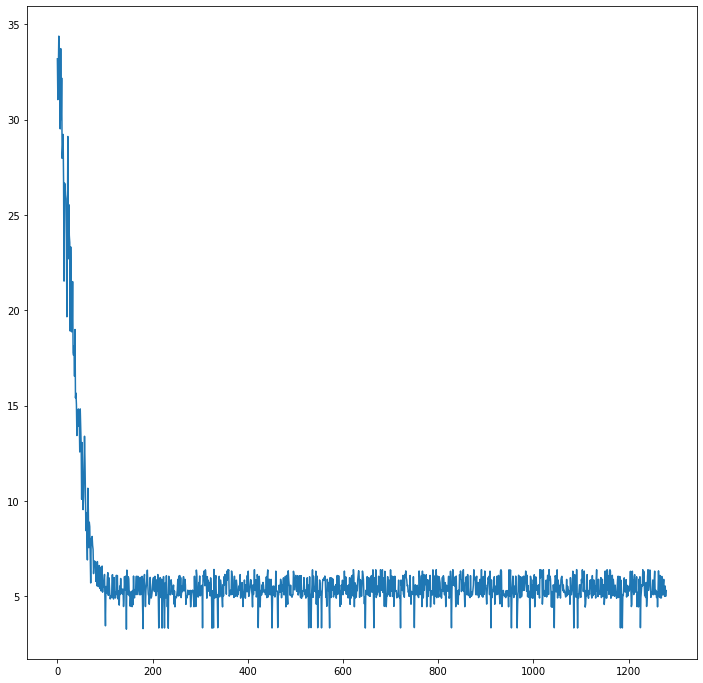

In [91]:
n = len(losses)
smooth = np.convolve(losses, np.ones((n,))/n, mode='valid')
plt.figure(figsize=(12, 12))
plt.plot(losses[::10])
plt.plot(smooth, c='r')

Looks converged to me!